In [1]:
%load_ext autoreload
%autoreload 2

#Misc
import time, os, sys, pdb
from glob import glob
from fnmatch import fnmatch

#Base
import numpy as np
import pandas as pd
import scipy.stats as st

#Save
import json
import scipy.io as sio
import h5py
import io_dict_to_hdf5 as ioh5

#Plot
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages
# cmap = usrplt.gradient_cmap(usrplt.color_palette)
sns.set_style("ticks")

#Model
import ssm

#User
import util
import plotting as usrplt


In [101]:
##===== Read in Data =====##
data_df = pd.read_hdf('./data/jumping_data_102220.h5')
nTrials = len(data_df)
data_df.head()

,expdate,subject,condition,platform,distance,success,laser_trial,jump_time,trial,fps,...,Side LEar y,Top LEar y,Side LEar likelihood,Top LEar likelihood,Side TakeFL x,Top TakeFL x,Side TakeFL y,Top TakeFL y,Side TakeFL likelihood,Top TakeFL likelihood
0,061920,J157BLT,control,2,8,2,laser off,125,1,60,...,"[425.385317744935, 366.33104528399747, 307.276...","[410.1932973761308, 352.0100881476151, 293.743...","[0.9999992847442627, 0.9999996423721313, 0.999...","[0.9999997615814209, 0.9999998807907104, 0.999...","[343.8412719726563, 458.4371704101562, 573.033...","[314.5657470703125, 419.42099609375003, 524.27...","[449.0091425115412, 384.95652410333804, 320.90...","[401.4983811248759, 342.47820290221966, 283.45...","[0.999998927116394, 0.9999992847442627, 0.9999...","[0.022194653749465942, 0.013417750597000122, 0..."
1,061920,J157BLT,control,1,20,2,laser off,222,2,60,...,"[433.1472437062976, 376.13851567895387, 319.12...","[410.46880031185265, 353.5964736516964, 296.65...","[0.9999973773956299, 0.9999958276748657, 0.999...","[0.9999992847442627, 0.9999996423721313, 0.999...","[343.52678222656255, 458.06650390625003, 572.6...","[312.7005615234375, 416.93408203125, 521.16760...","[447.5615396573399, 383.70670567296486, 319.85...","[404.90802086255826, 346.7887886848239, 288.66...","[0.9999996423721313, 0.9999996423721313, 0.999...","[0.04482194781303406, 0.06799852848052979, 0.0..."
2,061920,J157BLT,control,3,8,1,laser off,355,3,60,...,"[407.3741518887608, 348.01848782626075, 288.58...","[361.26440623890267, 306.1514179576527, 251.19...","[0.9999998807907104, 0.9999998807907104, 0.999...","[0.9999997615814209, 0.9999997615814209, 0.999...","[343.5391479492188, 457.974072265625, 572.3549...","[314.574169921875, 419.43222656250003, 524.290...","[446.51506847034796, 382.5187916148792, 318.38...","[402.4329915364583, 344.60011800130206, 286.76...","[0.9999998807907104, 0.9999998211860657, 0.999...","[0.8656889796257019, 0.7850416302680969, 0.630..."
3,061920,J157BLT,control,1,12,1,laser off,514,4,60,...,"[426.17190549660387, 369.09125364113515, 311.7...","[375.1970238334944, 319.0105187065413, 262.857...","[0.9999997615814209, 0.9999995231628418, 0.999...","[0.9999972581863403, 0.9999987483024597, 0.999...","[343.9951171875, 458.68979492187503, 573.36568...","[315.40451660156253, 420.53935546875005, 525.6...","[448.9589674068071, 385.0646436763384, 321.142...","[405.64251222127933, 347.9299939107325, 290.21...","[0.9999951720237732, 0.9999984502792358, 0.999...","[0.004946380853652954, 0.004948854446411133, 0..."
4,061920,J157BLT,control,2,12,0,laser off,651,5,60,...,"[429.43573380136877, 369.31512833261877, 308.8...","[354.6358043391531, 299.05050770829365, 243.60...","[1.0, 0.9999998807907104, 0.9999995231628418, ...","[0.9999991655349731, 0.9999986886978149, 0.999...","[343.91730957031257, 458.74045410156253, 573.5...","[313.2942993164063, 417.3133544921875, 521.236...","[446.6510607711668, 382.556981181323, 318.4961...","[403.01506375902665, 345.44733914965167, 287.8...","[0.9999997615814209, 0.9999998807907104, 0.999...","[0.9386019706726074, 0.956940770149231, 0.9827..."


In [102]:
#DLC tracking confidence threshold at which to mask out data
confidence_threshold = 0.8

#Loop over trials and reformat data for ARHMM
data_list = []; mask_list = []
for iTrial in range(nTrials):
    #Get coordinates of Take-Off platform
    xc = np.nanmean(data_df.loc[iTrial]['Side TakeFL x'])
    yc = np.nanmean(data_df.loc[iTrial]['Side TakeFL y'])
    
    xy_list = []; ll_list = []
    for ii, ptstr in enumerate(['Nose','LEye','LEar']):
        x = data_df.loc[iTrial]['Side {} x'.format(ptstr)]
        y = data_df.loc[iTrial]['Side {} y'.format(ptstr)]
        llhood = data_df.loc[iTrial]['Side {} likelihood'.format(ptstr)]
        
        #Coordinates relative to take-off platform
        xy_list.append((x-xc,y-yc))
        
        #Create mask for points that have a confidence lower than the given threshold
        mask = llhood > confidence_threshold
        ll_list.append((mask,mask))
    
    tmp = np.vstack(xy_list).T; data_list.append(tmp[2:-2,:])
    tmp = np.vstack(ll_list).T; mask_list.append(tmp[2:-2,:])



In [131]:
len(kDirs)

11

In [135]:
BaseDir = './results/ARHMM/Side_NEE-all_mice-2020-10-24_1310/'
kDirs = sorted(os.listdir(BaseDir))[1:-1]

ll_heldout = np.zeros((len(kDirs),6))
ll_training = np.zeros((len(kDirs),6))
Ks = np.arange(4,25,2).tolist()

for ii, kd in enumerate(kDirs):
    print('\n{}:'.format(kd),end='\t')
    
    #Load log-likelihood results for full fit
    fpath = glob(os.path.join(BaseDir,kd,'fit_parameters*.h5'))[0]
    data = ioh5.load(fpath)
    
    #Get K and directory to of kfolds
    K = int(kd[-2:])
    KDir = os.path.join(BaseDir,kd)
    
    ll_heldout[ii,-1] = data['ll_heldout_perstep']
    ll_training[ii,-1] = data['ll_training_perstep']
    
#     #Load MAP sequence results
#     fpath = glob(os.path.join(KDir,'MAP_seqs*.h5'))[0]
#     trMAPs, trPosteriors, trMasks, arhmm_params, opt = ioh5.load_MAP_seqs_h5(fpath)
#     opt['MAP_threshold'] = 0.75
#     trMasks2 = []
#     for post in trPosteriors:
#         max_prob = np.max(post,axis=1)
#         trMasks2.append(max_prob > opt['MAP_threshold'])
    
#     #Create temporary ARHMM for plotting functions 
#     arhmm = ssm.HMM(K, 6, observations='autoregressive',transitions='standard')
#     arhmm.init_state_distn.params = arhmm_params['init_state_distn']['P0']
#     arhmm.transitions.params = arhmm_params['transitions']['log_Ps']
#     arhmm.observations.As = arhmm_params['observations']['As']
#     arhmm.observations.bs = arhmm_params['observations']['bs']
          
#     ## Calculate & plot state duration and state usage 
#     state_duration_list, state_startend_list, state_usage = util.get_state_durations(trMAPs, trMasks2, K)
#     usrplt.plot_state_durations2(state_duration_list,state_usage, K,
#                             SAVEFIG=True,PlotDir=KDir,fname='state-durations_ARHMM-{}.pdf'.format(kd))

#     ## Plot example trajectories of actual trajectories for each state
#     usrplt.plot_example_trajectories(state_duration_list,state_startend_list,data_list, arhmm,
#                                     SAVEFIG=True,PlotDir=KDir,fname='state-trajectories_data_ARHMM-{}.pdf'.format(kd))

#     ## Plot example trajectories simulated from the model for each state
#     usrplt.plot_example_trajectories(state_duration_list,state_startend_list,data_list, arhmm, simulated=True,
#                                     SAVEFIG=True,PlotDir=KDir,fname='state-trajectories_simulated_ARHMM-{}.pdf'.format(kd))
    
#     usrplt.plot_example_state_sequences(trMAPs, trMasks2, data_list, K,
#                                 SAVEFIG=True,PlotDir=KDir,fname='state-sequences_ARHMM-{}.pdf'.format(kd))
    
#     ioh5.save(os.path.join(KDir, 'MAP_seqs-ARHMM-{}.h5'.format(kd)), 
#       {'trMAPs':trMAPs, 'trPosteriors':trPosteriors,'trMasks':trMasks2, 
#        'arhmm_params' : arhmm_params,'state_usage':state_usage, 
#        'hyperparams' : opt})
    
    kfold_dirs = sorted(glob(os.path.join(KDir,'kFold_*')))
#     pdb.set_trace()
    for jj,kfold in enumerate(kfold_dirs):
        fpath = glob(os.path.join(kfold,'fit_parameters*.h5'))[0]
        data = ioh5.load(fpath)
    
        ll_heldout[ii,jj] = data['ll_heldout_perstep']
        ll_training[ii,jj] = data['ll_training_perstep']


K_04:	

/home/dwyrick/projects/jumping_behavior/io_dict_to_hdf5.py:66: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  ans[key] = item.value



K_06:	
K_08:	
K_10:	
K_12:	
K_14:	
K_16:	
K_18:	
K_20:	
K_22:	
K_24:	

In [144]:
sorted(os.listdir(BaseDir))

['ARHMM_hyperparameters.json', 'K_04', 'K_06', 'K_08', 'K_10', 'K_12', 'K_14']

In [145]:
BaseDir = './results/ARHMM/Side_NEE-all_mice-2020-10-25_0940/'
kDirs = sorted(os.listdir(BaseDir))[1:]

ll_heldout_recurrent = np.zeros((len(kDirs),6))
ll_training_recurrent = np.zeros((len(kDirs),6))
Ks_recurrent = []

for ii, kd in enumerate(kDirs):
    print('\n{}:'.format(kd),end='\t')
    
    #Load log-likelihood results for full fit
    fpath = glob(os.path.join(BaseDir,kd,'fit_parameters*.h5'))[0]
    data = ioh5.load(fpath)
    
    #Get K and directory to of kfolds
    K = int(kd[-2:]); Ks_recurrent.append(K)
    KDir = os.path.join(BaseDir,kd)
    
    ll_heldout_recurrent[ii,-1] = data['ll_heldout_perstep']
    ll_training_recurrent[ii,-1] = data['ll_training_perstep']
       
    kfold_dirs = sorted(glob(os.path.join(KDir,'kFold_*')))
#     pdb.set_trace()
    for jj,kfold in enumerate(kfold_dirs):
        fpath = glob(os.path.join(kfold,'fit_parameters*.h5'))[0]
        data = ioh5.load(fpath)
    
        ll_heldout_recurrent[ii,jj] = data['ll_heldout_perstep']
        ll_training_recurrent[ii,jj] = data['ll_training_perstep']


K_04:	

/home/dwyrick/projects/jumping_behavior/io_dict_to_hdf5.py:66: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  ans[key] = item.value



K_06:	
K_08:	
K_10:	
K_12:	
K_14:	

Text(0.5, 1.0, 'Cross-Validated Log-Likelihood')

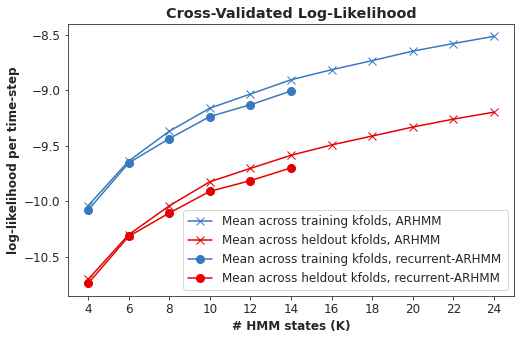

In [147]:
fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(Ks, np.mean(ll_training[:,:-1], axis=1), 'x-',color=usrplt.cc[0], markersize=8,label='Mean across training kfolds, ARHMM')
ax.plot(Ks, np.mean(ll_heldout[:,:-1], axis=1), 'x-',color=usrplt.cc[1], markersize=8,label='Mean across heldout kfolds, ARHMM ') 

ax.plot(Ks_recurrent, np.mean(ll_training_recurrent[:,:-1], axis=1), 'o-',color=usrplt.cc[0], markersize=8,label='Mean across training kfolds, recurrent-ARHMM')
ax.plot(Ks_recurrent, np.mean(ll_heldout_recurrent[:,:-1], axis=1), 'o-',color=usrplt.cc[1], markersize=8,label='Mean across heldout kfolds, recurrent-ARHMM ')    
ax.set_ylabel('log-likelihood per time-step')
ax.set_xlabel('# HMM states (K)')
ax.set_xticks(Ks)
ax.legend()

ax.set_title('Cross-Validated Log-Likelihood')
# plt.savefig('./plots/ARHMM_xvalidation.png')

In [45]:
BaseDir = './results/ARHMM/Side_NEE-all_mice-2020-10-24_1310/'

fpath = os.path.join(BaseDir,'K_20','MAP_seqs-ARHMM-K_20.h5')

results = ioh5.load(fpath)

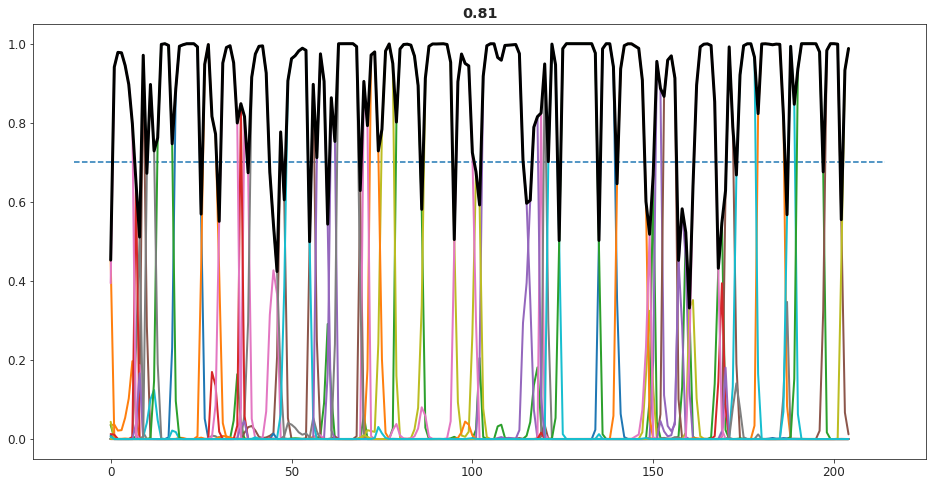

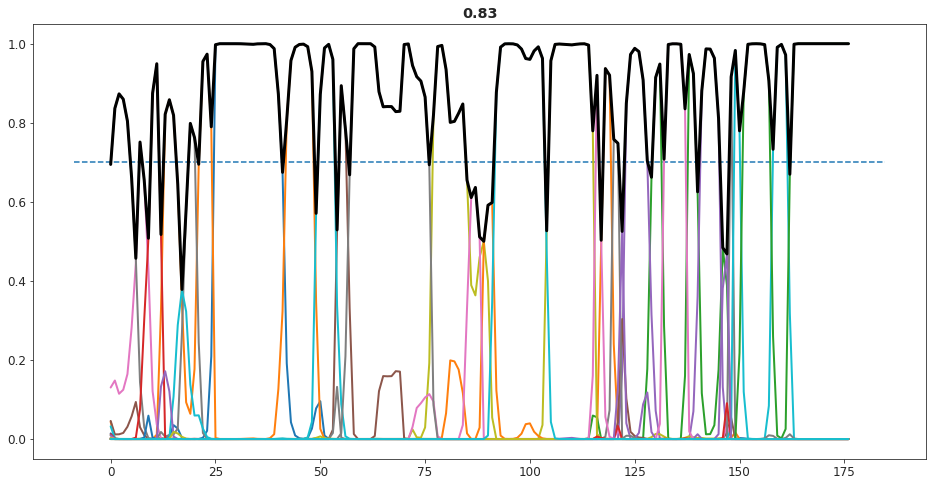

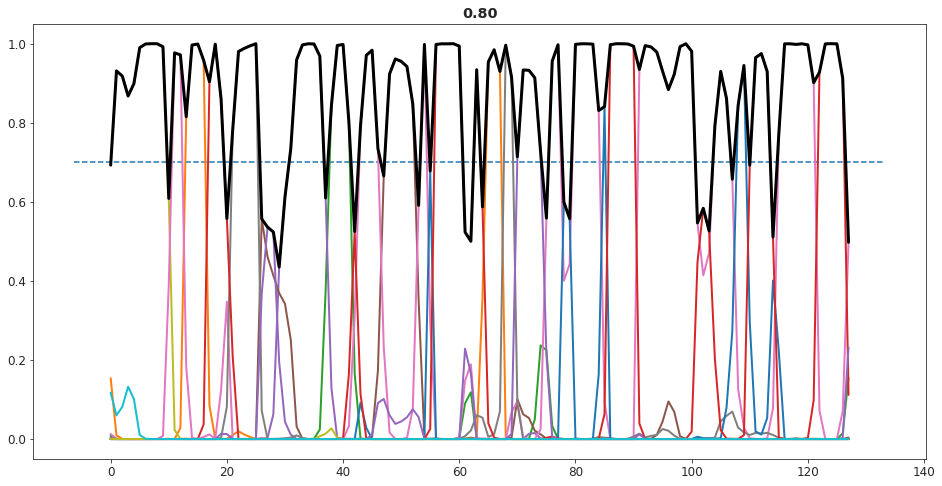

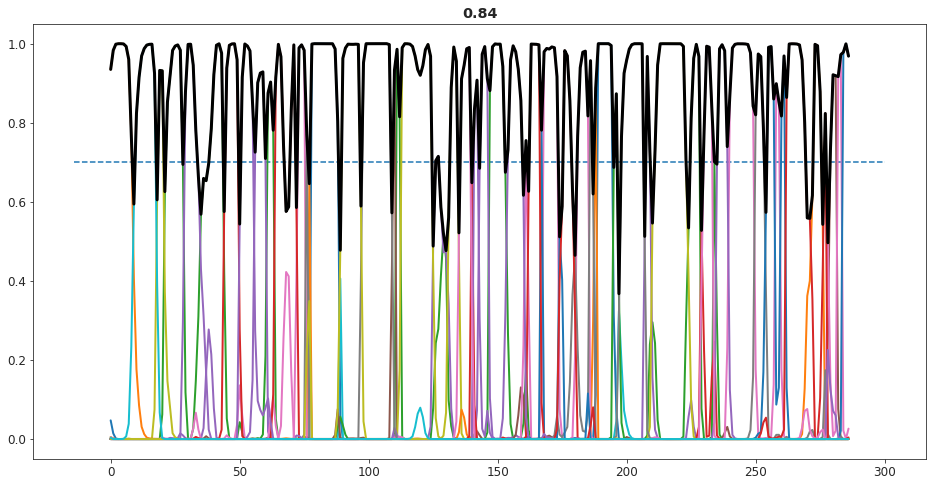

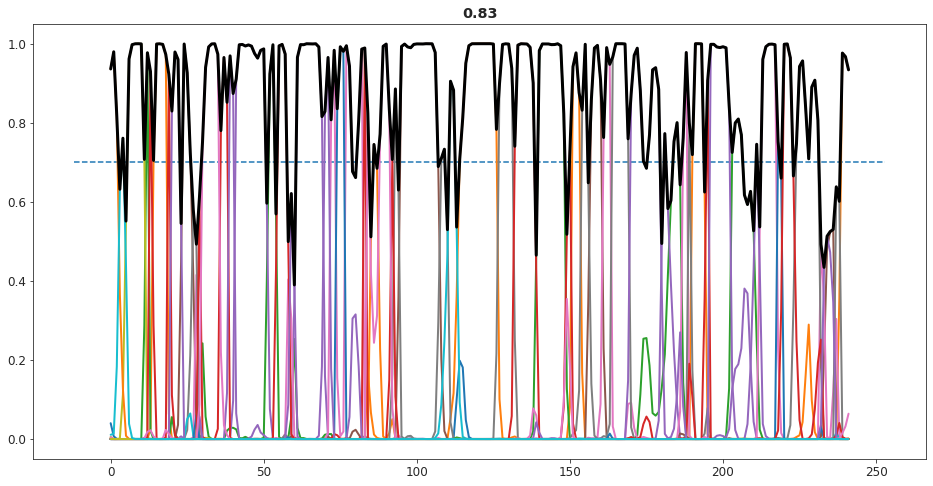

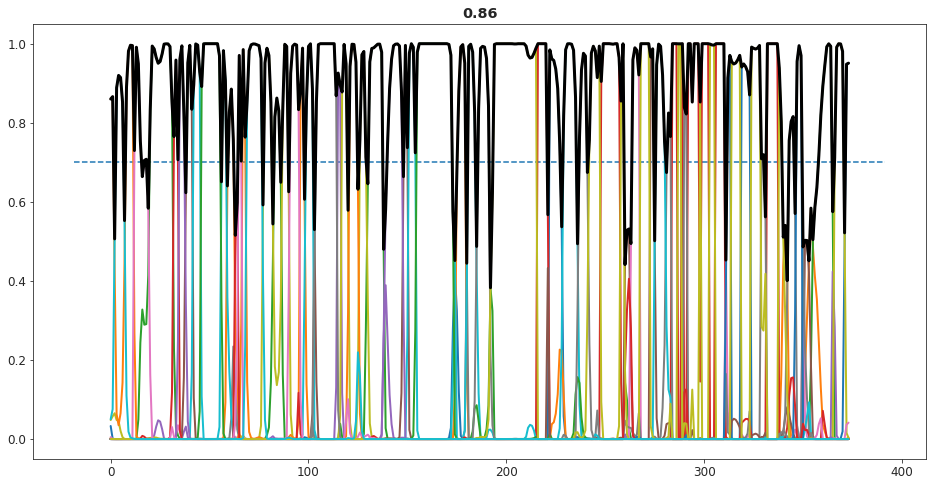

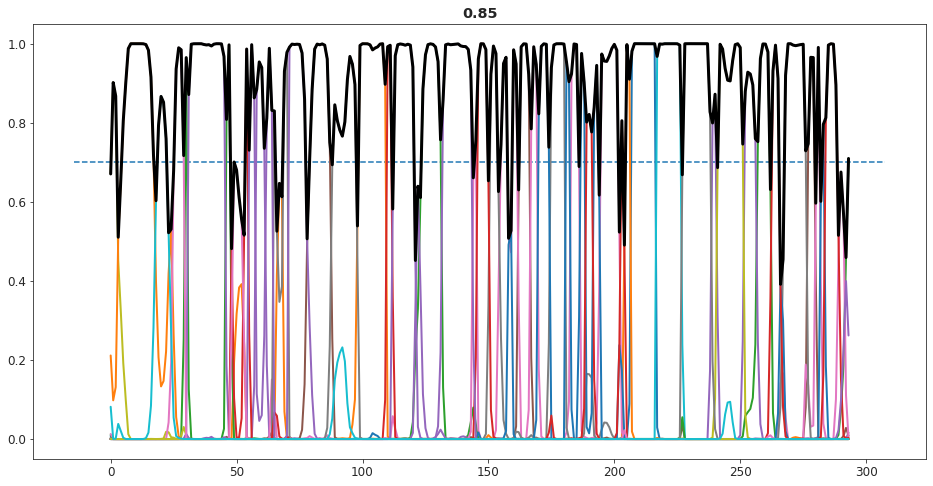

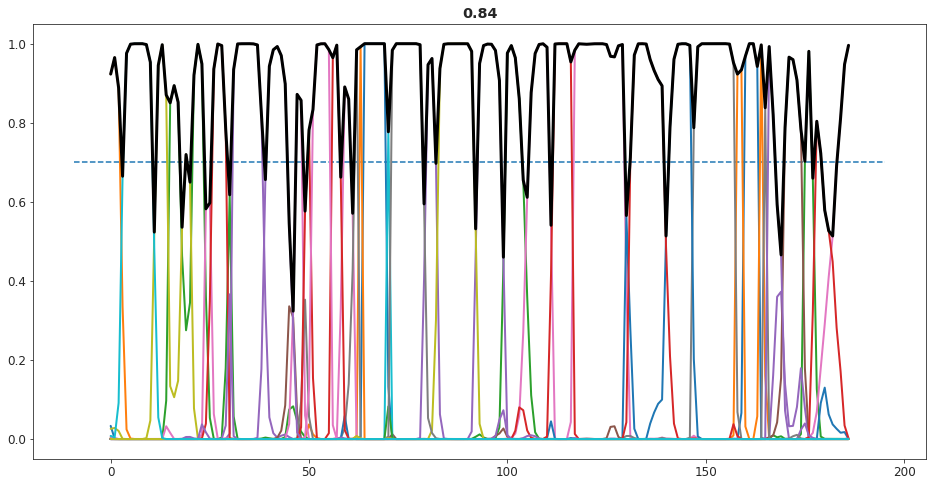

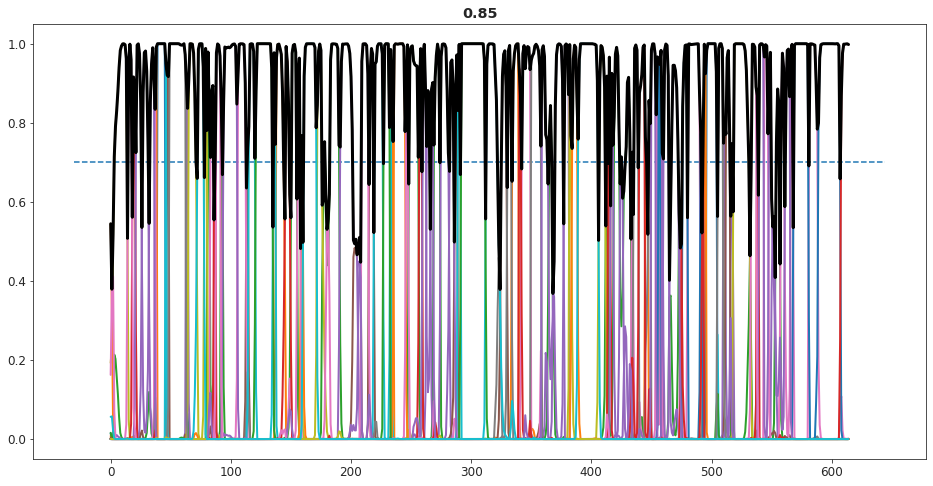

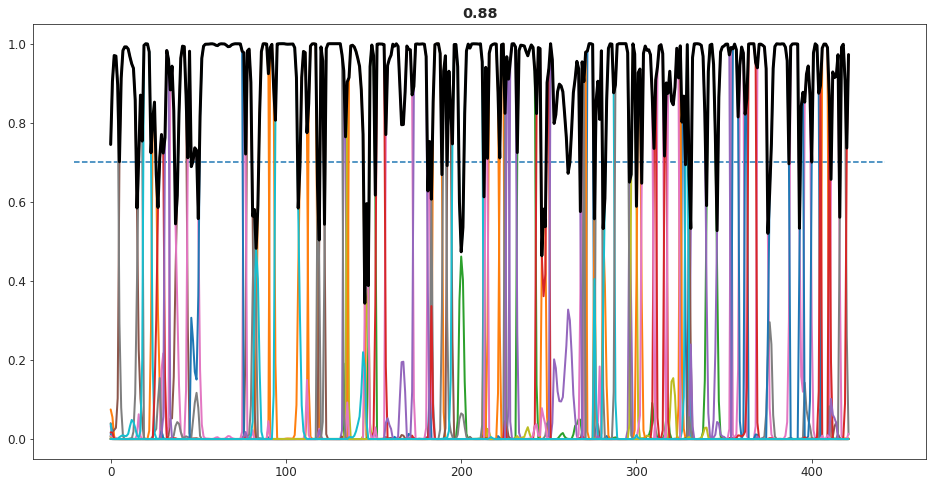

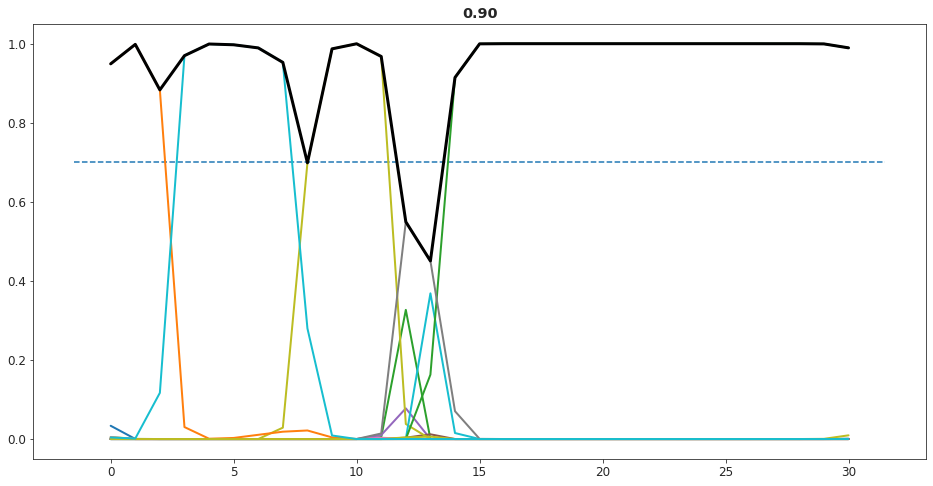

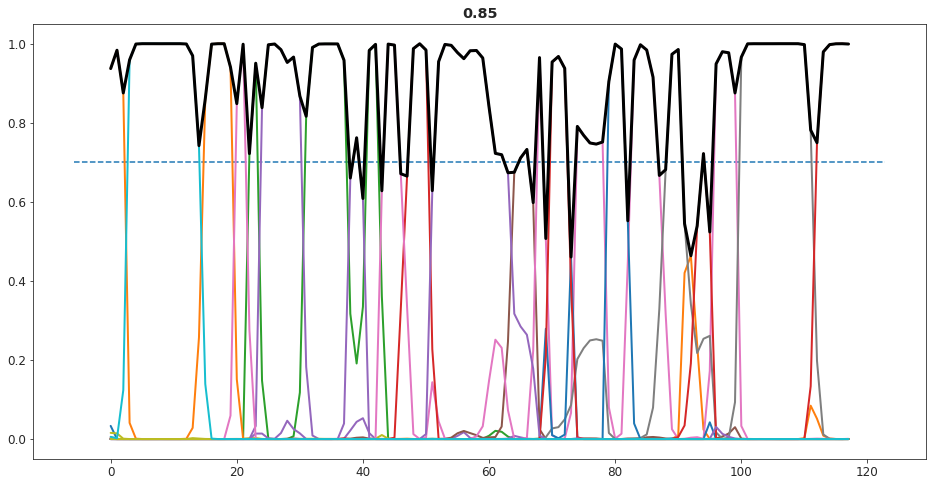

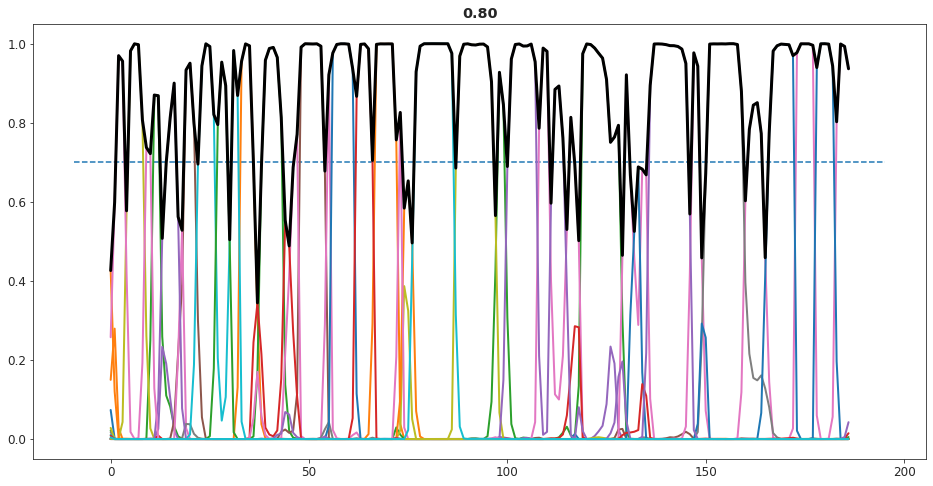

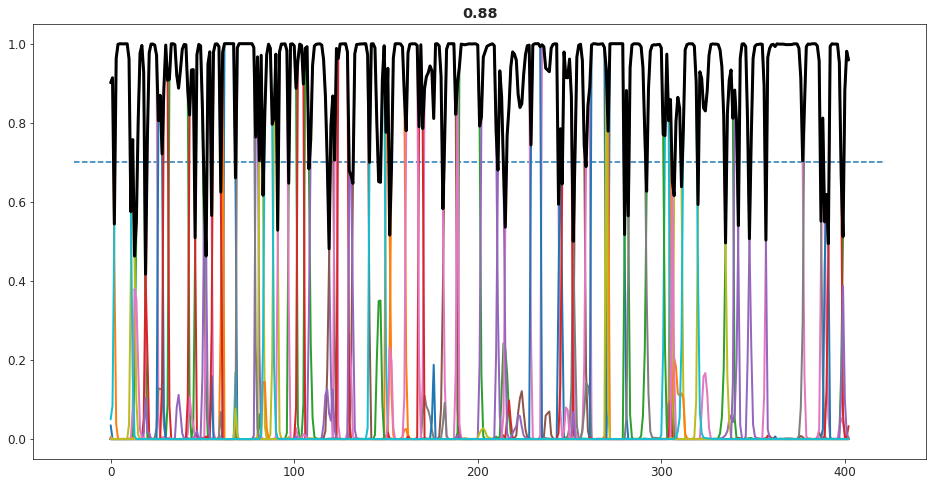

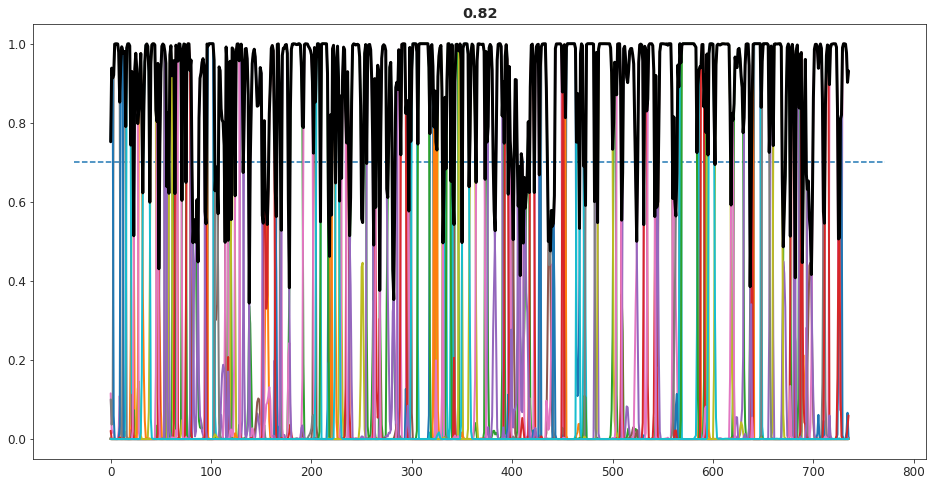

In [66]:
MAP_threshold = 0.7
for iTrial in range(15):
    nT, K = results['trPosteriors'][str(iTrial)].shape
    mPosterior = np.max(results['trPosteriors'][str(iTrial)],axis=1)
    fig, ax = plt.subplots(figsize=(16,8))
    plt.plot(results['trPosteriors'][str(iTrial)],'-',lw=2)
    plt.plot(mPosterior,'-k',lw=3)
    ax.hlines(0.7,*ax.get_xlim(),ls='--')
    ax.set_title('{:.2f}'.format(np.sum(mPosterior > MAP_threshold)/nT))

In [52]:
results['trMasks']['1']

array([ True, False, False, False, False,  True,  True,  True,  True,
        True, False, False,  True, False, False, False,  True,  True,
        True,  True,  True,  True, False, False,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False,  True, False, False, False,
       False, False, False, False,  True, False, False, False, False,
        True, False,  True,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True, False, False, False, False,
       False, False, False, False,  True,  True,  True,  True,  True,
        True,  True, False, False, False, False, False, False, False,
       False, False, False, False, False,  True, False, False, False,
       False, False, False, False, False, False, False,  True, False,
        True, False, False,  True,  True,  True, False, False, False,
       False, False,